In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
#from helpers.plot_helpers import *
import cmocean
import os
import warnings
warnings.filterwarnings("ignore")
import matplotlib as mpl
import cartopy.crs as ccrs

%load_ext autoreload
%autoreload 3

# Default matplotlib plotting parameters

In [2]:
import matplotlib
def default_rcParams(kw={}):
    '''
    Also matplotlib.rcParamsDefault contains the default values,
    but:
    - backend is changed
    - without plotting something as initialization,
    inline does not work
    '''
    plt.plot()
    plt.close()
    rcParams = matplotlib.rcParamsDefault.copy()
    
    # We do not change backend because it can break
    # inlining; Also, 'backend' key is broken and 
    # we cannot use pop method
    for key, val in rcParams.items():
        if key != 'backend':
            rcParams[key] = val

    matplotlib.rcParams.update({
        'font.family': 'MathJax_Main',
        'mathtext.fontset': 'cm',

        'figure.figsize': (4, 4),

        'figure.subplot.wspace': 0.3,
        
        'font.size': 14,
        #'axes.labelsize': 10,
        #'axes.titlesize': 12,
        #'xtick.labelsize': 10,
        #'ytick.labelsize': 10,
        #'legend.fontsize': 10,

        'axes.formatter.limits': (-2,3),
        'axes.formatter.use_mathtext': True,
        'axes.labelpad': 0,
        'axes.titlelocation' : 'center',
        
        'savefig.bbox': 'tight',
        'savefig.pad_inches': 0.1
    })
    matplotlib.rcParams.update(**kw)

# SST bias

In [3]:
def sort_longitude(x):
    x['lon'] = np.where(x['lon']>0, x['lon'], 360+x['lon'])
    x = x.sortby('lon')
    return x
def regrid_to_1x1(sst_R4, lon, lat):
    # Coarse with grid box 4x4
    sst_R1 = sst_R4.coarsen({'xh':4, 'yh':4}, boundary='trim').mean()
    # Rename coordinates:
    sst_R1 = sst_R1.rename({'xh':'lon', 'yh':'lat'})
    # Sort coordinates:
    sst_R1 = sort_longitude(sst_R1)
    # Interpolate to WOA grid
    sst_R1 = sst_R1.interp({'lon': lon, 'lat': lat})
    return sst_R1.compute()

In [4]:
# Read WOA data
woa = sort_longitude(xr.open_dataset('/vast/pp2681/WOA/woa_1981_2010.nc', decode_times=False).t_an.isel(depth=0).isel(time=0))

In [5]:
'''
Read simulation data:
* Average over 3 years at the surface
* Adjust coordinate names
* Coarsen to 1x1 grid
* Adjust NaN values
'''
# Read simulation data:
# Average over 3 years, coarsen to 1x1 grid, adjust
# coordinate names
selector = lambda file_path: xr.where(np.isnan(woa), np.nan,
                             regrid_to_1x1(
                             xr.open_mfdataset(file_path).thetao.isel(z_l=0).isel(time=slice(-36,None)).mean('time'), 
                             woa.lon, woa.lat).compute())

In [6]:
om4 = selector('/scratch/pp2681/mom6/OM4_SIS2/unparameterized/output/*ocean_month_z*')
zb20 = selector('/scratch/pp2681/mom6/OM4_SIS2/ZB20-Reynolds/output/*ocean_month_z*')
ann_redline = selector('/scratch/pp2681/mom6/OM4_SIS2/ANN-redline/output/*ocean_month_z*')
ann_greenline = selector('/scratch/pp2681/mom6/OM4_SIS2/ANN-greenline/output/*ocean_month_z*')
om4_003 = selector('/scratch/pp2681/mom6/OM4_SIS2/unparameterized-0.03/output/*ocean_month_z*')
om4_009 = selector('/scratch/pp2681/mom6/OM4_SIS2/unparameterized-0.09/output/*ocean_month_z*')
zb20_nofilters = selector('/scratch/pp2681/mom6/OM4_SIS2/ZB20-Klower/output/*ocean_month_z*')
vert_diff = selector('/scratch/pp2681/mom6/OM4_SIS2/vert-diff/output/*ocean_month_z*')
jhah15 = selector('/scratch/pp2681/mom6/OM4_SIS2/JHAH15/output/*ocean_month_z*')
om5 = selector('/scratch/pp2681/mom6/OM4_SIS2/unparameterized-OM5/output/*ocean_month_z*')
gm = selector('/scratch/pp2681/mom6/OM4_SIS2/GM/output/*ocean_month_z*')

Text(0.5, 1.0, 'OM4 SST bias \n mean=$-0.10$ $C^o$, RMSE=$0.65$ $C^o$')

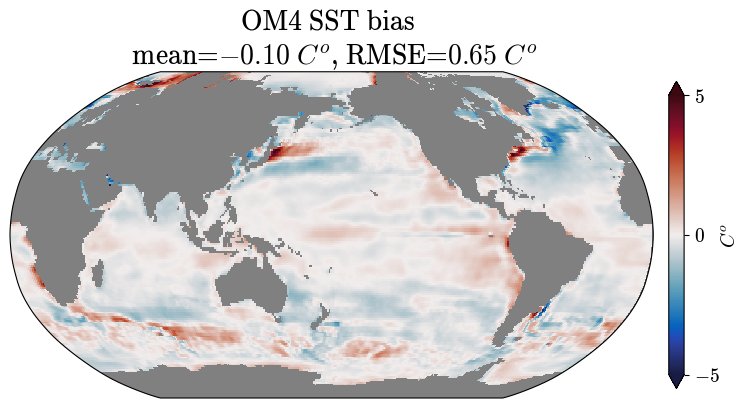

In [7]:
default_rcParams()
import cmocean
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
fig, axes = plt.subplots(1,1, figsize=(10, 7), 
subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})

ax = axes
cmap = cmocean.cm.balance
cmap.set_bad('gray')
data = om4-woa
im = data.plot.imshow(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, add_colorbar=False, vmin=-5,vmax=5, interpolation='none')
rmse = np.sqrt(np.nanmean(data**2))
mean = np.nanmean(data)

cb = plt.colorbar(im, pad=0.02, ax=axes, extend='both', aspect=20, shrink=0.57)
cb.set_label(label='$C^o$')
cb.ax.set_yticks([-5, 0, 5])
plt.title('OM4 SST bias \n mean=$%.2f$ $C^o$, RMSE=$%.2f$ $C^o$' % (mean, rmse), fontsize=20)

Text(0.5, 1.0, 'ZB20-Reynolds SST bias \n mean=$-0.03$ $C^o$, RMSE=$0.65$ $C^o$')

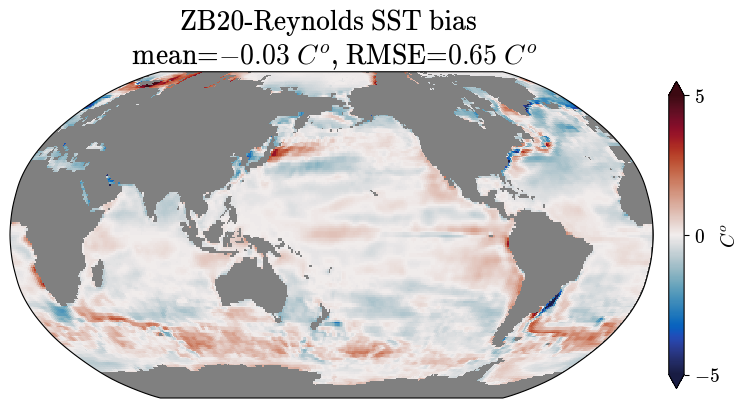

In [10]:
default_rcParams()
import cmocean
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
fig, axes = plt.subplots(1,1, figsize=(10, 7), 
subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})

ax = axes
cmap = cmocean.cm.balance
cmap.set_bad('gray')
data = zb20-woa
im = data.plot.imshow(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, add_colorbar=False, vmin=-5,vmax=5, interpolation='none')
rmse = np.sqrt(np.nanmean(data**2))
mean = np.nanmean(data)

cb = plt.colorbar(im, pad=0.02, ax=axes, extend='both', aspect=20, shrink=0.57)
cb.set_label(label='$C^o$')
cb.ax.set_yticks([-5, 0, 5])
plt.title('ZB20-Reynolds SST bias \n mean=$%.2f$ $C^o$, RMSE=$%.2f$ $C^o$' % (mean, rmse), fontsize=20)

Text(0.5, 1.0, 'ANN with filters SST bias \n mean=$-0.03$ $C^o$, RMSE=$0.64$ $C^o$')

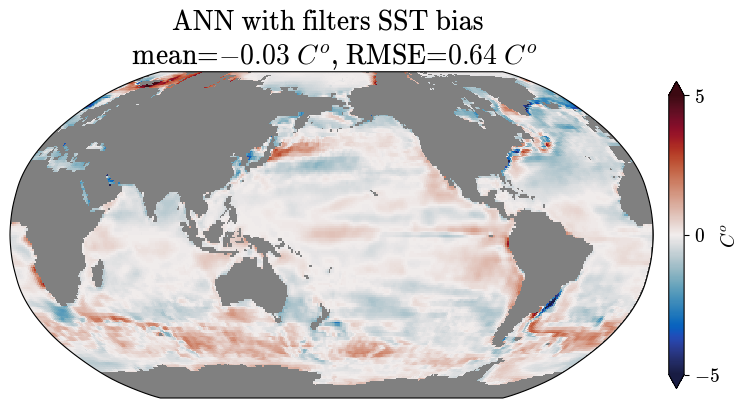

In [17]:
default_rcParams()
import cmocean
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
fig, axes = plt.subplots(1,1, figsize=(10, 7), 
subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})

ax = axes
cmap = cmocean.cm.balance
cmap.set_bad('gray')
data = ann_redline-woa
im = data.plot.imshow(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, add_colorbar=False, vmin=-5,vmax=5, interpolation='none')
rmse = np.sqrt(np.nanmean(data**2))
mean = np.nanmean(data)

cb = plt.colorbar(im, pad=0.02, ax=axes, extend='both', aspect=20, shrink=0.57)
cb.set_label(label='$C^o$')
cb.ax.set_yticks([-5, 0, 5])
plt.title('ANN with filters SST bias \n mean=$%.2f$ $C^o$, RMSE=$%.2f$ $C^o$' % (mean, rmse), fontsize=20)

Text(0.5, 1.0, 'ANN without filters SST bias \n mean=$-0.04$ $C^o$, RMSE=$0.65$ $C^o$')

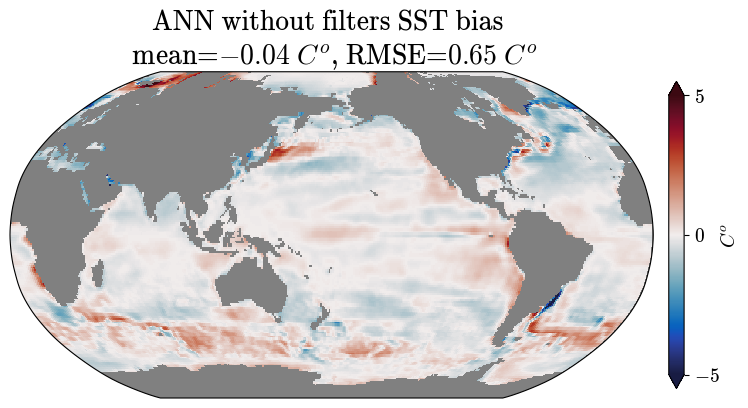

In [13]:
default_rcParams()
import cmocean
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
fig, axes = plt.subplots(1,1, figsize=(10, 7), 
subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})

ax = axes
cmap = cmocean.cm.balance
cmap.set_bad('gray')
data = ann_greenline-woa
im = data.plot.imshow(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, add_colorbar=False, vmin=-5,vmax=5, interpolation='none')
rmse = np.sqrt(np.nanmean(data**2))
mean = np.nanmean(data)

cb = plt.colorbar(im, pad=0.02, ax=axes, extend='both', aspect=20, shrink=0.57)
cb.set_label(label='$C^o$')
cb.ax.set_yticks([-5, 0, 5])
plt.title('ANN without filters SST bias \n mean=$%.2f$ $C^o$, RMSE=$%.2f$ $C^o$' % (mean, rmse), fontsize=20)

Text(0.5, 1.0, 'ZB20-Reynolds SST response')

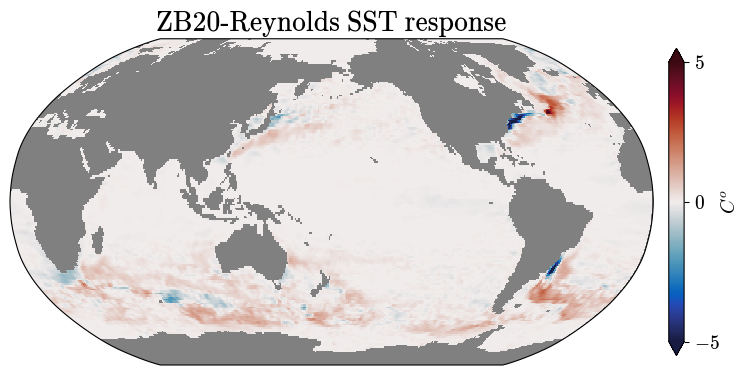

In [14]:
default_rcParams()
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
fig, axes = plt.subplots(1,1, figsize=(10, 7), 
subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})

ax = axes
im = (zb20-om4).plot.imshow(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, add_colorbar=False, vmin=-5,vmax=5, interpolation='none')

cb = plt.colorbar(im, pad=0.02, ax=axes, extend='both', aspect=20, shrink=0.57)
cb.set_label(label='$C^o$')
cb.ax.set_yticks([-5, 0, 5])
plt.title('ZB20-Reynolds SST response', fontsize=20)

Text(0.5, 1.0, 'ANN with filters SST response')

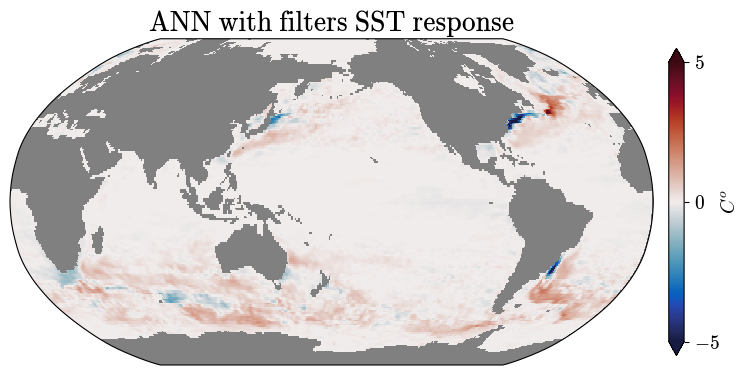

In [15]:
default_rcParams()
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
fig, axes = plt.subplots(1,1, figsize=(10, 7), 
subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})

ax = axes
im = (ann_redline-om4).plot.imshow(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, add_colorbar=False, vmin=-5,vmax=5, interpolation='none')

cb = plt.colorbar(im, pad=0.02, ax=axes, extend='both', aspect=20, shrink=0.57)
cb.set_label(label='$C^o$')
cb.ax.set_yticks([-5, 0, 5])
plt.title('ANN with filters SST response', fontsize=20)

Text(0.5, 1.0, 'ANN without filters SST response')

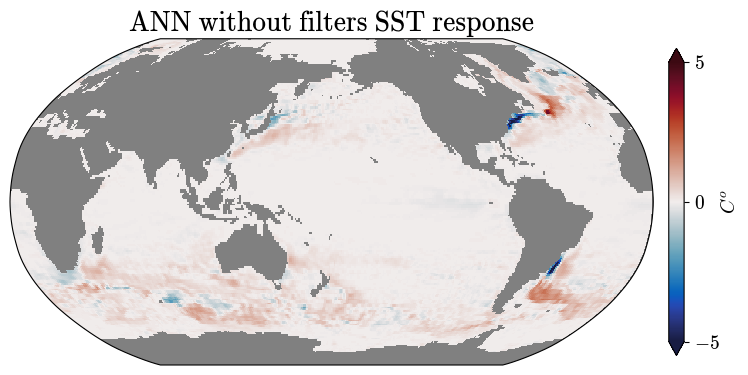

In [16]:
default_rcParams()
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
fig, axes = plt.subplots(1,1, figsize=(10, 7), 
subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})

ax = axes
im = (ann_greenline-om4).plot.imshow(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, add_colorbar=False, vmin=-5,vmax=5, interpolation='none')

cb = plt.colorbar(im, pad=0.02, ax=axes, extend='both', aspect=20, shrink=0.57)
cb.set_label(label='$C^o$')
cb.ax.set_yticks([-5, 0, 5])
plt.title('ANN without filters SST response', fontsize=20)

Text(0.5, 1.0, '$C_S=0.03$ SST response')

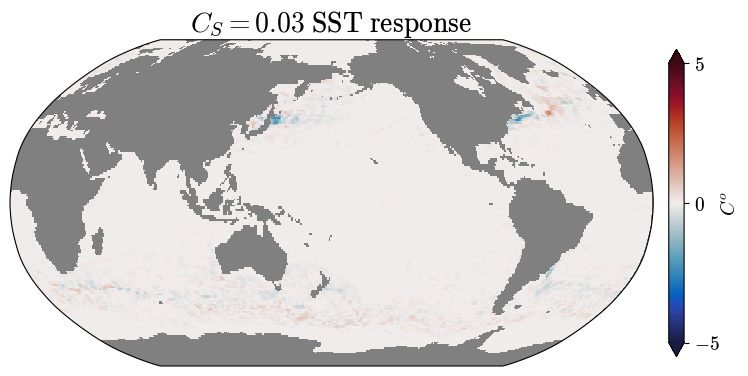

In [10]:
default_rcParams()
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
fig, axes = plt.subplots(1,1, figsize=(10, 7), 
subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})

ax = axes
im = (om4_003-om4).plot.imshow(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, add_colorbar=False, vmin=-5,vmax=5, interpolation='none')

cb = plt.colorbar(im, pad=0.02, ax=axes, extend='both', aspect=20, shrink=0.57)
cb.set_label(label='$C^o$')
cb.ax.set_yticks([-5, 0, 5])
plt.title('$C_S=0.03$ SST response', fontsize=20)

Text(0.5, 1.0, '$C_S=0.09$ SST response')

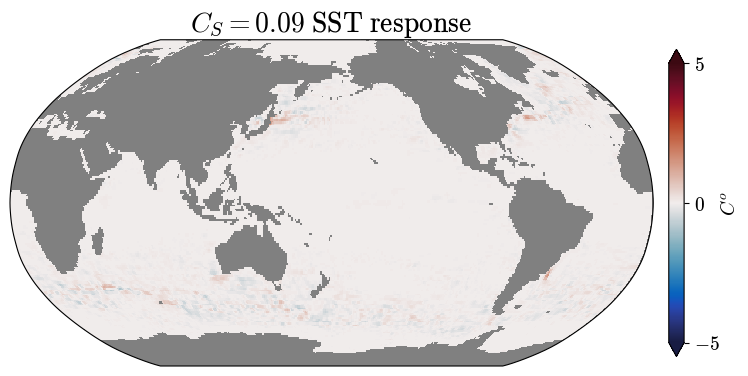

In [11]:
default_rcParams()
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
fig, axes = plt.subplots(1,1, figsize=(10, 7), 
subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})

ax = axes
im = (om4_009-om4).plot.imshow(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, add_colorbar=False, vmin=-5,vmax=5, interpolation='none')

cb = plt.colorbar(im, pad=0.02, ax=axes, extend='both', aspect=20, shrink=0.57)
cb.set_label(label='$C^o$')
cb.ax.set_yticks([-5, 0, 5])
plt.title('$C_S=0.09$ SST response', fontsize=20)

Text(0.5, 1.0, 'ZB20 without filters SST response')

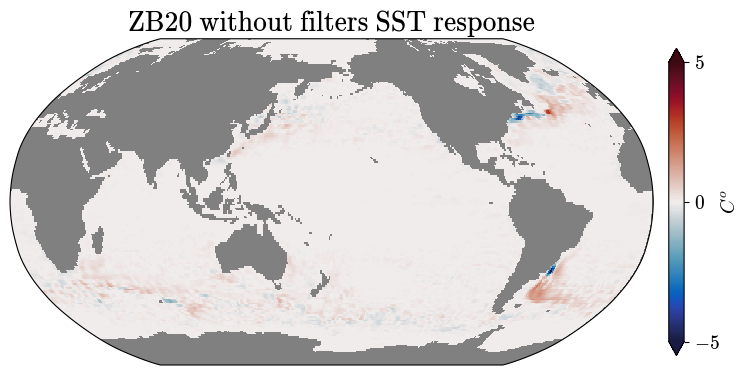

In [20]:
default_rcParams()
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
fig, axes = plt.subplots(1,1, figsize=(10, 7), 
subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})

ax = axes
im = (zb20_nofilters-om4).plot.imshow(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, add_colorbar=False, vmin=-5,vmax=5, interpolation='none')

cb = plt.colorbar(im, pad=0.02, ax=axes, extend='both', aspect=20, shrink=0.57)
cb.set_label(label='$C^o$')
cb.ax.set_yticks([-5, 0, 5])
plt.title('ZB20 without filters SST response', fontsize=20)

Text(0.5, 1.0, 'Vert. diff SST response')

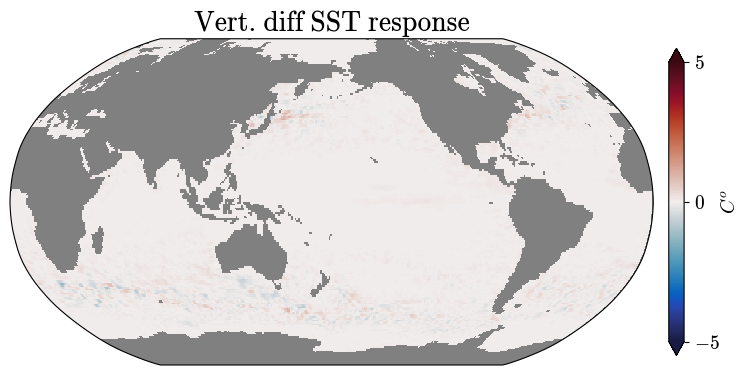

In [27]:
default_rcParams()
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
fig, axes = plt.subplots(1,1, figsize=(10, 7), 
subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})

ax = axes
im = (vert_diff-om4).plot.imshow(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, add_colorbar=False, vmin=-5,vmax=5, interpolation='none')

cb = plt.colorbar(im, pad=0.02, ax=axes, extend='both', aspect=20, shrink=0.57)
cb.set_label(label='$C^o$')
cb.ax.set_yticks([-5, 0, 5])
plt.title('Vert. diff SST response', fontsize=20)

Text(0.5, 1.0, 'OM5 SST response')

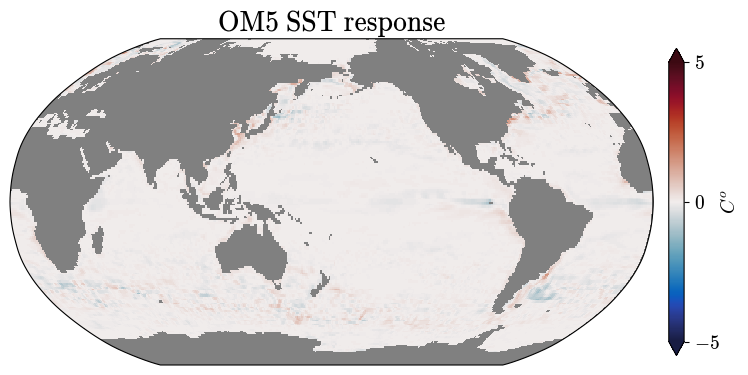

In [26]:
default_rcParams()
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
fig, axes = plt.subplots(1,1, figsize=(10, 7), 
subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})

ax = axes
im = (om5-om4).plot.imshow(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, add_colorbar=False, vmin=-5,vmax=5, interpolation='none')

cb = plt.colorbar(im, pad=0.02, ax=axes, extend='both', aspect=20, shrink=0.57)
cb.set_label(label='$C^o$')
cb.ax.set_yticks([-5, 0, 5])
plt.title('OM5 SST response', fontsize=20)

Text(0.5, 1.0, 'JHAH15 SST response')

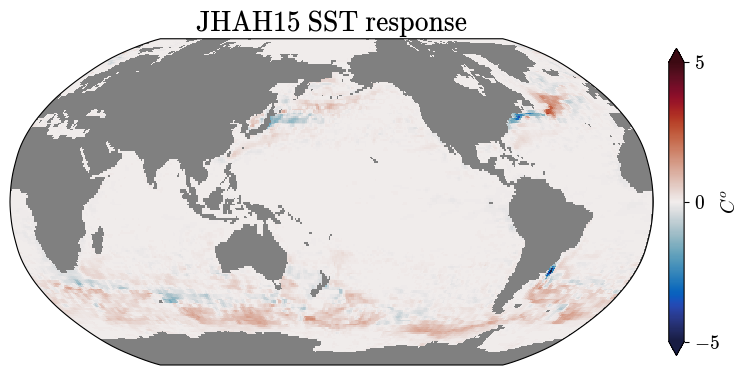

In [25]:
default_rcParams()
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
fig, axes = plt.subplots(1,1, figsize=(10, 7), 
subplot_kw={'projection': ccrs.Robinson(central_longitude=180)})

ax = axes
im = (jhah15-om4).plot.imshow(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, add_colorbar=False, vmin=-5,vmax=5, interpolation='none')

cb = plt.colorbar(im, pad=0.02, ax=axes, extend='both', aspect=20, shrink=0.57)
cb.set_label(label='$C^o$')
cb.ax.set_yticks([-5, 0, 5])
plt.title('JHAH15 SST response', fontsize=20)

Text(0.5, 1.0, 'OM4 SST bias,\n mean=$-0.52$ $C^o$, RMSE=$1.12$ $C^o$')

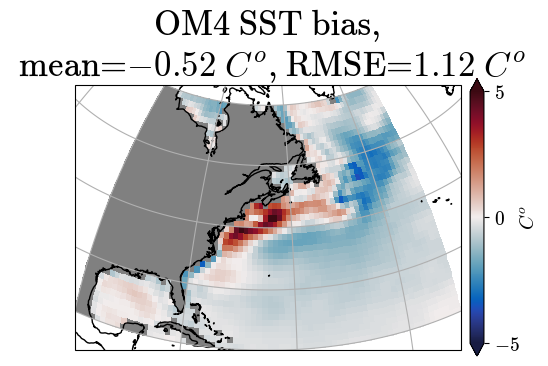

In [9]:
default_rcParams()
import cmocean
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
lat=slice(20,60); lon=slice(260,330)
fig, axes = plt.subplots(1,1, figsize=(6, 6), 
subplot_kw={'projection': ccrs.Orthographic(central_latitude=(lat.start+lat.stop)/2, central_longitude=(lon.start+lon.stop)/2)})

ax = axes
data = (om4-woa).sel(lat=lat,lon=lon)
im = data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, add_colorbar=False, vmin=-5,vmax=5)
ax.coastlines()
ax.gridlines()

rmse = np.sqrt(np.nanmean(data**2))
mean = np.nanmean(data)

cb = plt.colorbar(im, pad=0.02, ax=axes, extend='both', aspect=20, shrink=0.6)
cb.set_label(label='$C^o$')
cb.ax.set_yticks([-5, 0, 5])
plt.title(f'OM4 SST bias,\n mean=$%.2f$ $C^o$, RMSE=$%.2f$ $C^o$' % (mean, rmse), fontsize=25)

Text(0.5, 1.0, 'ZB20-Reynolds SST bias,\n mean=$-0.43$ $C^o$, RMSE=$0.84$ $C^o$')

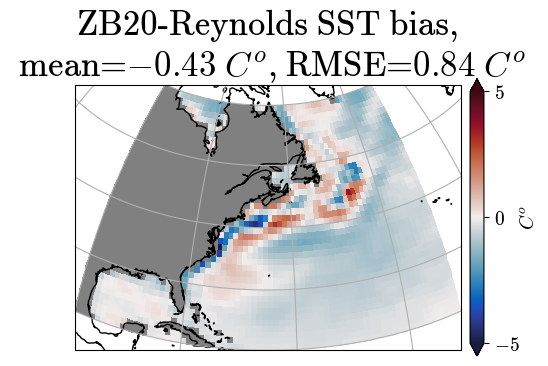

In [10]:
default_rcParams()
import cmocean
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
lat=slice(20,60); lon=slice(260,330)
fig, axes = plt.subplots(1,1, figsize=(6, 6), 
subplot_kw={'projection': ccrs.Orthographic(central_latitude=(lat.start+lat.stop)/2, central_longitude=(lon.start+lon.stop)/2)})

ax = axes
data = (zb20-woa).sel(lat=lat,lon=lon)
im = data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, add_colorbar=False, vmin=-5,vmax=5)
ax.coastlines()
ax.gridlines()

rmse = np.sqrt(np.nanmean(data**2))
mean = np.nanmean(data)

cb = plt.colorbar(im, pad=0.02, ax=axes, extend='both', aspect=20, shrink=0.6)
cb.set_label(label='$C^o$')
cb.ax.set_yticks([-5, 0, 5])
plt.title(f'ZB20-Reynolds SST bias,\n mean=$%.2f$ $C^o$, RMSE=$%.2f$ $C^o$' % (mean, rmse), fontsize=25)

Text(0.5, 1.0, 'ANN with filters SST bias,\n mean=$-0.45$ $C^o$, RMSE=$0.82$ $C^o$')

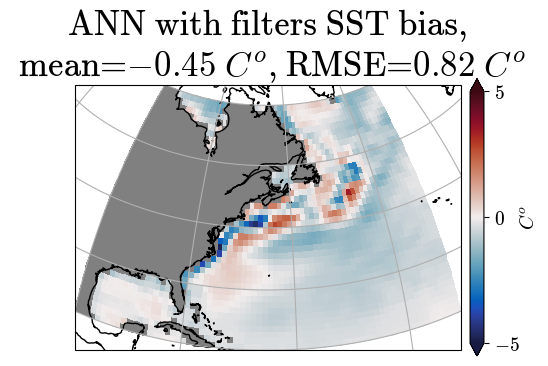

In [11]:
default_rcParams()
import cmocean
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
lat=slice(20,60); lon=slice(260,330)
fig, axes = plt.subplots(1,1, figsize=(6, 6), 
subplot_kw={'projection': ccrs.Orthographic(central_latitude=(lat.start+lat.stop)/2, central_longitude=(lon.start+lon.stop)/2)})

ax = axes
data = (ann_redline-woa).sel(lat=lat,lon=lon)
im = data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, add_colorbar=False, vmin=-5,vmax=5)
ax.coastlines()
ax.gridlines()

rmse = np.sqrt(np.nanmean(data**2))
mean = np.nanmean(data)

cb = plt.colorbar(im, pad=0.02, ax=axes, extend='both', aspect=20, shrink=0.6)
cb.set_label(label='$C^o$')
cb.ax.set_yticks([-5, 0, 5])
plt.title(f'ANN with filters SST bias,\n mean=$%.2f$ $C^o$, RMSE=$%.2f$ $C^o$' % (mean, rmse), fontsize=25)

Text(0.5, 1.0, 'ANN without filters SST bias,\n mean=$-0.46$ $C^o$, RMSE=$0.84$ $C^o$')

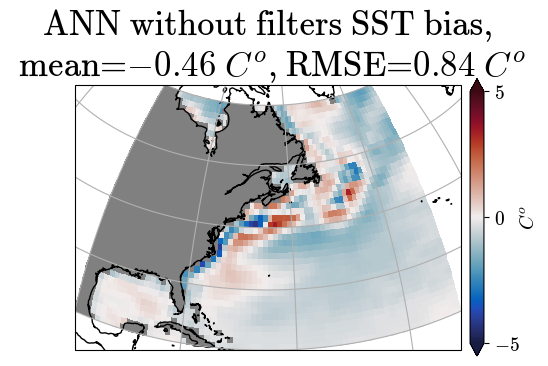

In [12]:
default_rcParams()
import cmocean
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
lat=slice(20,60); lon=slice(260,330)
fig, axes = plt.subplots(1,1, figsize=(6, 6), 
subplot_kw={'projection': ccrs.Orthographic(central_latitude=(lat.start+lat.stop)/2, central_longitude=(lon.start+lon.stop)/2)})

ax = axes
data = (ann_greenline-woa).sel(lat=lat,lon=lon)
im = data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, add_colorbar=False, vmin=-5,vmax=5)
ax.coastlines()
ax.gridlines()

rmse = np.sqrt(np.nanmean(data**2))
mean = np.nanmean(data)

cb = plt.colorbar(im, pad=0.02, ax=axes, extend='both', aspect=20, shrink=0.6)
cb.set_label(label='$C^o$')
cb.ax.set_yticks([-5, 0, 5])
plt.title(f'ANN without filters SST bias,\n mean=$%.2f$ $C^o$, RMSE=$%.2f$ $C^o$' % (mean, rmse), fontsize=25)

Text(0.5, 1.0, 'JHAH15 SST bias,\n mean=$-0.47$ $C^o$, RMSE=$0.90$ $C^o$')

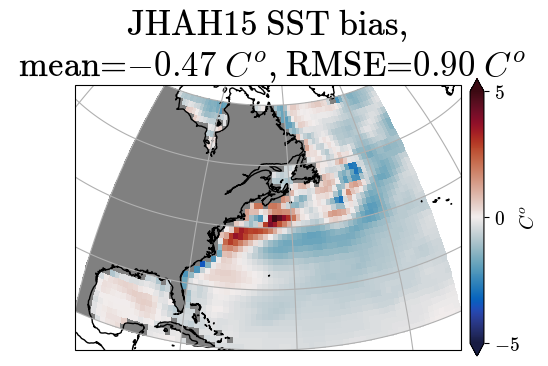

In [14]:
default_rcParams()
import cmocean
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
lat=slice(20,60); lon=slice(260,330)
fig, axes = plt.subplots(1,1, figsize=(6, 6), 
subplot_kw={'projection': ccrs.Orthographic(central_latitude=(lat.start+lat.stop)/2, central_longitude=(lon.start+lon.stop)/2)})

ax = axes
data = (jhah15-woa).sel(lat=lat,lon=lon)
im = data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, add_colorbar=False, vmin=-5,vmax=5)
ax.coastlines()
ax.gridlines()

rmse = np.sqrt(np.nanmean(data**2))
mean = np.nanmean(data)

cb = plt.colorbar(im, pad=0.02, ax=axes, extend='both', aspect=20, shrink=0.6)
cb.set_label(label='$C^o$')
cb.ax.set_yticks([-5, 0, 5])
plt.title(f'JHAH15 SST bias,\n mean=$%.2f$ $C^o$, RMSE=$%.2f$ $C^o$' % (mean, rmse), fontsize=25)

Text(0.5, 1.0, 'ZB20 without filters SST bias,\n mean=$-0.51$ $C^o$, RMSE=$0.95$ $C^o$')

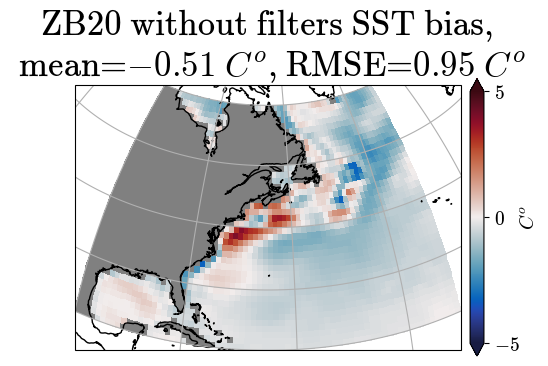

In [13]:
default_rcParams()
import cmocean
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
lat=slice(20,60); lon=slice(260,330)
fig, axes = plt.subplots(1,1, figsize=(6, 6), 
subplot_kw={'projection': ccrs.Orthographic(central_latitude=(lat.start+lat.stop)/2, central_longitude=(lon.start+lon.stop)/2)})

ax = axes
data = (zb20_nofilters-woa).sel(lat=lat,lon=lon)
im = data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, add_colorbar=False, vmin=-5,vmax=5)
ax.coastlines()
ax.gridlines()

rmse = np.sqrt(np.nanmean(data**2))
mean = np.nanmean(data)

cb = plt.colorbar(im, pad=0.02, ax=axes, extend='both', aspect=20, shrink=0.6)
cb.set_label(label='$C^o$')
cb.ax.set_yticks([-5, 0, 5])
plt.title(f'ZB20 without filters SST bias,\n mean=$%.2f$ $C^o$, RMSE=$%.2f$ $C^o$' % (mean, rmse), fontsize=25)

Text(0.5, 1.0, '$C_S=0.03$ SST bias,\n mean=$-0.52$ $C^o$, RMSE=$0.99$ $C^o$')

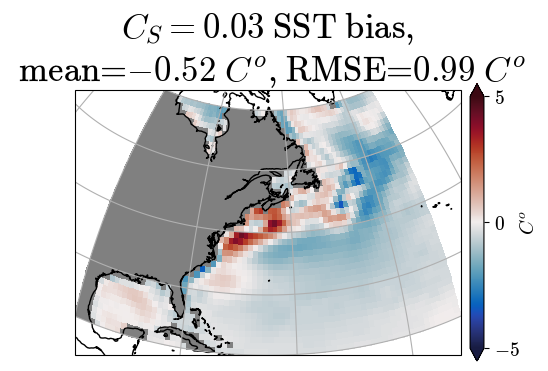

In [15]:
default_rcParams()
import cmocean
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
lat=slice(20,60); lon=slice(260,330)
fig, axes = plt.subplots(1,1, figsize=(6, 6), 
subplot_kw={'projection': ccrs.Orthographic(central_latitude=(lat.start+lat.stop)/2, central_longitude=(lon.start+lon.stop)/2)})

ax = axes
data = (om4_003-woa).sel(lat=lat,lon=lon)
im = data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, add_colorbar=False, vmin=-5,vmax=5)
ax.coastlines()
ax.gridlines()

rmse = np.sqrt(np.nanmean(data**2))
mean = np.nanmean(data)

cb = plt.colorbar(im, pad=0.02, ax=axes, extend='both', aspect=20, shrink=0.6)
cb.set_label(label='$C^o$')
cb.ax.set_yticks([-5, 0, 5])
plt.title(f'$C_S=0.03$ SST bias,\n mean=$%.2f$ $C^o$, RMSE=$%.2f$ $C^o$' % (mean, rmse), fontsize=25)

0.9313562844227093


Text(0.5, 1.0, 'ZB20-Reynolds SST response')

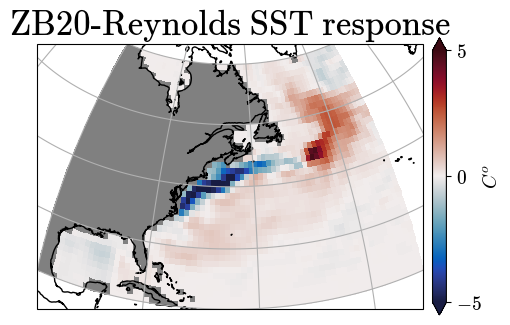

In [31]:
default_rcParams()
import cmocean
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
lat=slice(20,60); lon=slice(260,330)
fig, axes = plt.subplots(1,1, figsize=(6, 6), 
subplot_kw={'projection': ccrs.Orthographic(central_latitude=(lat.start+lat.stop)/2, central_longitude=(lon.start+lon.stop)/2)})

ax = axes
data = (zb20-om4).sel(lat=lat,lon=lon)
print(data.std().item())
im = data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, add_colorbar=False, vmin=-5,vmax=5)
ax.coastlines()
ax.gridlines()

cb = plt.colorbar(im, pad=0.02, ax=axes, extend='both', aspect=20, shrink=0.6)
cb.set_label(label='$C^o$')
cb.ax.set_yticks([-5, 0, 5])
plt.title('ZB20-Reynolds SST response', fontsize=25)

0.9104269859444504


Text(0.5, 1.0, 'ANN with filters SST response')

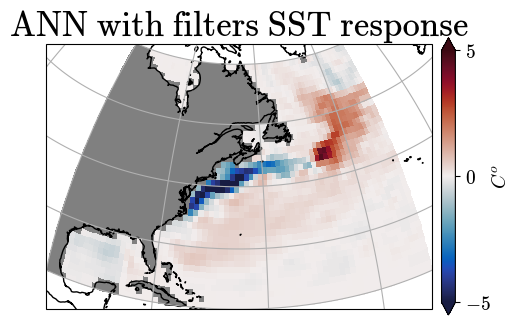

In [30]:
default_rcParams()
import cmocean
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
lat=slice(20,60); lon=slice(260,330)
fig, axes = plt.subplots(1,1, figsize=(6, 6), 
subplot_kw={'projection': ccrs.Orthographic(central_latitude=(lat.start+lat.stop)/2, central_longitude=(lon.start+lon.stop)/2)})

ax = axes
data = (ann_redline-om4).sel(lat=lat,lon=lon)
print(data.std().item())
im = data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, add_colorbar=False, vmin=-5,vmax=5)
ax.coastlines()
ax.gridlines()

cb = plt.colorbar(im, pad=0.02, ax=axes, extend='both', aspect=20, shrink=0.6)
cb.set_label(label='$C^o$')
cb.ax.set_yticks([-5, 0, 5])
plt.title('ANN with filters SST response', fontsize=25)

0.8472100102459033


Text(0.5, 1.0, 'ANN without filters SST response')

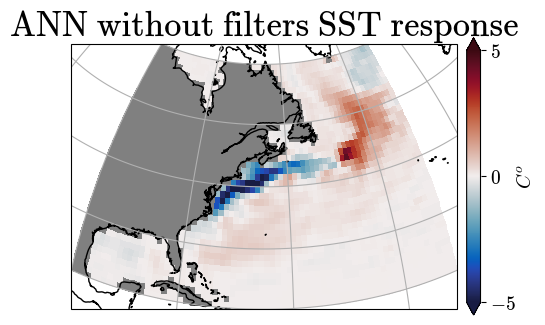

In [13]:
default_rcParams()
import cmocean
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
lat=slice(20,60); lon=slice(260,330)
fig, axes = plt.subplots(1,1, figsize=(6, 6), 
subplot_kw={'projection': ccrs.Orthographic(central_latitude=(lat.start+lat.stop)/2, central_longitude=(lon.start+lon.stop)/2)})

ax = axes
data = (ann_greenline-om4).sel(lat=lat,lon=lon)
print(data.std().item())
im = data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, add_colorbar=False, vmin=-5,vmax=5)
ax.coastlines()
ax.gridlines()

cb = plt.colorbar(im, pad=0.02, ax=axes, extend='both', aspect=20, shrink=0.6)
cb.set_label(label='$C^o$')
cb.ax.set_yticks([-5, 0, 5])
plt.title('ANN without filters SST response', fontsize=25)

0.2802485552232172


Text(0.5, 1.0, '$C_S=0.03$ SST response')

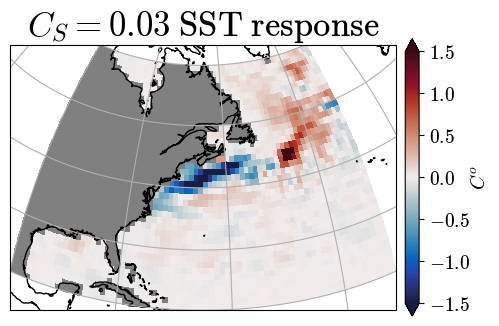

In [19]:
default_rcParams()
import cmocean
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
lat=slice(20,60); lon=slice(260,330)
fig, axes = plt.subplots(1,1, figsize=(6, 6), 
subplot_kw={'projection': ccrs.Orthographic(central_latitude=(lat.start+lat.stop)/2, central_longitude=(lon.start+lon.stop)/2)})

ax = axes
data = (om4_003-om4).sel(lat=lat,lon=lon)
print(data.std().item())
im = data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, add_colorbar=False, vmin=-1.5,vmax=1.5)
ax.coastlines()
ax.gridlines()

cb = plt.colorbar(im, pad=0.02, ax=axes, extend='both', aspect=20, shrink=0.6)
cb.set_label(label='$C^o$')
#cb.ax.set_yticks([-1, 0, 1.5])
plt.title('$C_S=0.03$ SST response', fontsize=25)

0.15513918407233596


Text(0.5, 1.0, '$C_S=0.09$ SST response')

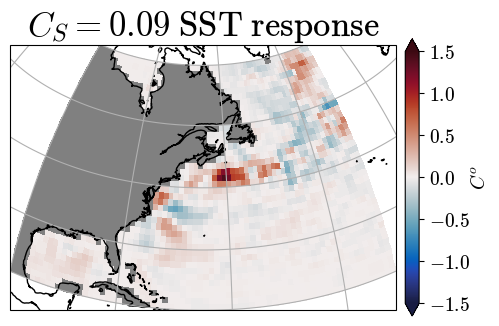

In [20]:
default_rcParams()
import cmocean
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
lat=slice(20,60); lon=slice(260,330)
fig, axes = plt.subplots(1,1, figsize=(6, 6), 
subplot_kw={'projection': ccrs.Orthographic(central_latitude=(lat.start+lat.stop)/2, central_longitude=(lon.start+lon.stop)/2)})

ax = axes
data = (om4_009-om4).sel(lat=lat,lon=lon)
print(data.std().item())
im = data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, add_colorbar=False, vmin=-1.5,vmax=1.5)
ax.coastlines()
ax.gridlines()

cb = plt.colorbar(im, pad=0.02, ax=axes, extend='both', aspect=20, shrink=0.6)
cb.set_label(label='$C^o$')
#cb.ax.set_yticks([-5, 0, 5])
plt.title('$C_S=0.09$ SST response', fontsize=25)

0.4593610356233249


Text(0.5, 1.0, 'ZB20 without filters SST response')

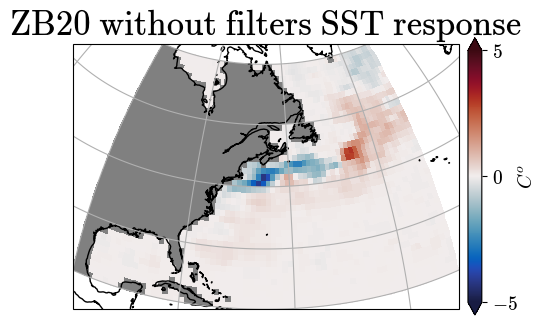

In [10]:
default_rcParams()
import cmocean
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
lat=slice(20,60); lon=slice(260,330)
fig, axes = plt.subplots(1,1, figsize=(6, 6), 
subplot_kw={'projection': ccrs.Orthographic(central_latitude=(lat.start+lat.stop)/2, central_longitude=(lon.start+lon.stop)/2)})
cmap = cmocean.cm.balance
cmap.set_bad('gray')

ax = axes
data = (zb20_nofilters-om4).sel(lat=lat,lon=lon)
print(data.std().item())
im = data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, add_colorbar=False, vmin=-5,vmax=5)
ax.coastlines()
ax.gridlines()

cb = plt.colorbar(im, pad=0.02, ax=axes, extend='both', aspect=20, shrink=0.6)
cb.set_label(label='$C^o$')
cb.ax.set_yticks([-5, 0, 5])
plt.title('ZB20 without filters SST response', fontsize=25)

0.11435396891960499


Text(0.5, 1.0, 'Reducing vert. diff. SST response')

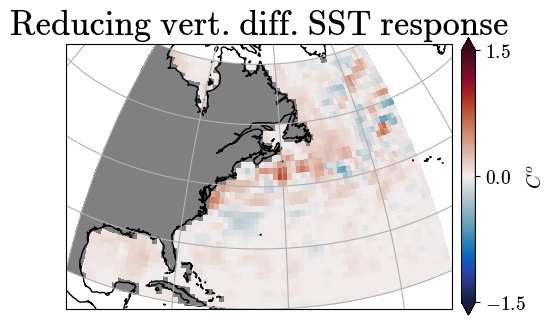

In [19]:
default_rcParams()
import cmocean
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
lat=slice(20,60); lon=slice(260,330)
fig, axes = plt.subplots(1,1, figsize=(6, 6), 
subplot_kw={'projection': ccrs.Orthographic(central_latitude=(lat.start+lat.stop)/2, central_longitude=(lon.start+lon.stop)/2)})
cmap = cmocean.cm.balance
cmap.set_bad('gray')

ax = axes
data = (vert_diff-om4).sel(lat=lat,lon=lon)
print(data.std().item())
im = data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, add_colorbar=False, vmin=-1.5,vmax=1.5)
ax.coastlines()
ax.gridlines()

cb = plt.colorbar(im, pad=0.02, ax=axes, extend='both', aspect=20, shrink=0.6)
cb.set_label(label='$C^o$')
cb.ax.set_yticks([-1.5, 0, 1.5])
plt.title('Reducing vert. diff. SST response', fontsize=25)

0.5135279686870118


Text(0.5, 1.0, 'JHAH15 SST response')

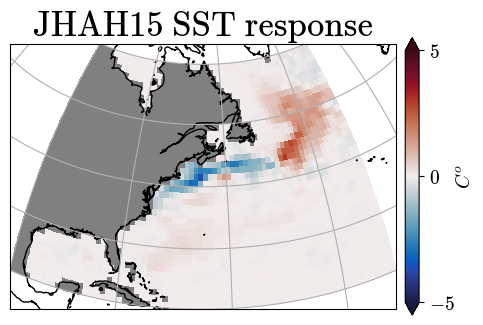

In [14]:
default_rcParams()
import cmocean
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
lat=slice(20,60); lon=slice(260,330)
fig, axes = plt.subplots(1,1, figsize=(6, 6), 
subplot_kw={'projection': ccrs.Orthographic(central_latitude=(lat.start+lat.stop)/2, central_longitude=(lon.start+lon.stop)/2)})
cmap = cmocean.cm.balance
cmap.set_bad('gray')

ax = axes
data = (jhah15-om4).sel(lat=lat,lon=lon)
print(data.std().item())
im = data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, add_colorbar=False, vmin=-5,vmax=5)
ax.coastlines()
ax.gridlines()

cb = plt.colorbar(im, pad=0.02, ax=axes, extend='both', aspect=20, shrink=0.6)
cb.set_label(label='$C^o$')
cb.ax.set_yticks([-5, 0, 5])
plt.title('JHAH15 SST response', fontsize=25)

0.44913531596547734


Text(0.5, 1.0, 'GM SST response')

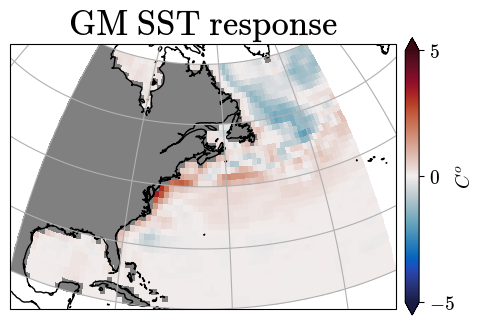

In [19]:
default_rcParams()
import cmocean
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
lat=slice(20,60); lon=slice(260,330)
fig, axes = plt.subplots(1,1, figsize=(6, 6), 
subplot_kw={'projection': ccrs.Orthographic(central_latitude=(lat.start+lat.stop)/2, central_longitude=(lon.start+lon.stop)/2)})
cmap = cmocean.cm.balance
cmap.set_bad('gray')

ax = axes
data = (gm-om4).sel(lat=lat,lon=lon)
print(data.std().item())
im = data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, add_colorbar=False, vmin=-5,vmax=5)
ax.coastlines()
ax.gridlines()

cb = plt.colorbar(im, pad=0.02, ax=axes, extend='both', aspect=20, shrink=0.6)
cb.set_label(label='$C^o$')
cb.ax.set_yticks([-5, 0, 5])
plt.title('GM SST response', fontsize=25)

0.19630386128205893


Text(0.5, 1.0, '"OM5" SST response')

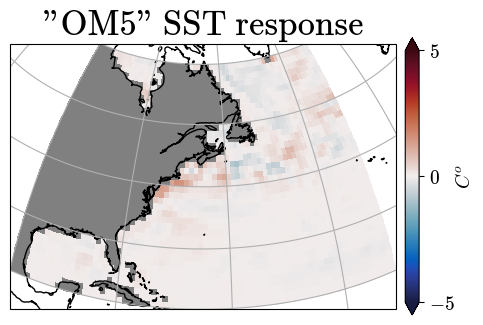

In [13]:
default_rcParams()
import cmocean
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
lat=slice(20,60); lon=slice(260,330)
fig, axes = plt.subplots(1,1, figsize=(6, 6), 
subplot_kw={'projection': ccrs.Orthographic(central_latitude=(lat.start+lat.stop)/2, central_longitude=(lon.start+lon.stop)/2)})
cmap = cmocean.cm.balance
cmap.set_bad('gray')

ax = axes
data = (om5-om4).sel(lat=lat,lon=lon)
print(data.std().item())
im = data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, add_colorbar=False, vmin=-5,vmax=5)
ax.coastlines()
ax.gridlines()

cb = plt.colorbar(im, pad=0.02, ax=axes, extend='both', aspect=20, shrink=0.6)
cb.set_label(label='$C^o$')
cb.ax.set_yticks([-5, 0, 5])
plt.title('"OM5" SST response', fontsize=25)